In [1]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

In [104]:
class CW2KM:
    def __init__(self, n_clusters, gamma, max_iter=25, p=2):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.max_iter = max_iter
        self.p = p

    def fit(self, V):
        self.K = np.array([rbf_kernel(x, gamma=self.gamma) for x in V])

        n = self.K[0].shape[0]
        self.U = np.zeros((n, self.n_clusters))
        self.weights = np.full((len(V), self.n_clusters), 1 / len(V))

        for i in range(self.max_iter):
            # Updating the cluster indicator matrix U
            self.U *= 0
            for j in range(n):
                dist = []
                for v in range(len(V)):  
                    v_dist = []
                    for k in range(self.n_clusters):
                        K_ii = np.diag(self.K[v])
                        if(np.sum(self.U[:, k]) != 0):
                            K_ij = np.sum(self.U[:, k] * self.K[v][:, j])/np.sum(self.U[:, k])
                        else:
                            K_ij = 0
                        soorat = 0
                        makhraj = 0
                        for l in range(0, n):
                            for m in range(0, n):
                                soorat += self.U[l, k] * self.U[m, k] * self.K[v][l, m]
                                makhraj += self.U[l, k] * self.U[m, k]
                        K_jj = soorat/makhraj
                        # K_jj = np.sum(self.U[:n, k][:, np.newaxis] * self.U[:n, k] * self.K[v])\
                        #         /np.sum(self.U[:n, k][:, np.newaxis] * self.U[:n, k] * self.K[v])
                        d = K_ii - 2 * K_ij + K_jj
                        v_dist.append(d * (self.weights[v, k] ** self.p))
                    # dist = [self.kernel_dist(k, j) for k in range(self.n_clusters)]
                    dist.append(v_dist)
                self.U[j, np.argmin(np.array(dist), axis=1)] = 1

            # Updating the cluster weight ω_vk
            # Sum-of-squared errors of the kth cluster in the vth view
            D = np.zeros((len(V), self.n_clusters))
            for v in range(len(V)):  
                D_vk = 0
                for k in range(self.n_clusters):
                    for j in range(n):
                        K_ii = np.diag(self.K[v]).mean()
                        K_ij = np.sum(self.U[:, k] * self.K[v][:, j]) / np.sum(self.U[:, k])
                        soorat = 0
                        makhraj = 0
                        for l in range(0, n):
                            for m in range(0, n):
                                soorat += self.U[l, k] * self.U[m, k] * self.K[v][l, m]
                                makhraj += self.U[l, k] * self.U[m, k]
                        K_jj = soorat/makhraj
                        # K_jj = np.sum(self.U[:n, k][:, np.newaxis] * self.U[:n, k] * self.K[v])\
                        #         /np.sum(self.U[:n, k][:, np.newaxis] * self.U[:n, k] * self.K[v])
                        d = K_ii - 2 * K_ij + K_jj
                        D_vk += self.U[j, k] * d
                    D[v, k] += D_vk

            # D = np.zeros((len(V), self.n_clusters))
            # # K_ii = np.mean(np.diagonal(self.K, axis1=1, axis2=2), axis=1)
            # K_ii = np.diagonal(self.K, axis1=1, axis2=2)
            # K_ii = np.diagonal(self.K.transpose(2, 0, 1))
            # print(K_ii.shape)

            # for k in range(self.n_clusters):
            #     K_ij = np.sum(self.U[:, k, np.newaxis] * self.K, axis=0) / np.sum(self.U[:, k])
            #     # K_jj = np.sum(self.U[:, k, np.newaxis] * self.U[:, k] * self.K, axis=0) \
            #     #     / np.sum(self.U[:, k, np.newaxis] * self.U[:, k])
            #     K_jj = np.sum(self.U[:, k, np.newaxis] * self.U[:, k, np.newaxis] * self.K) \
            #         / np.sum(self.U[:, k, np.newaxis] * self.U[:, k])
            #     d = K_ii - 2 * K_ij + K_jj
            #     D_vk = np.sum(self.U[:, k, np.newaxis] * d, axis=0)
            #     D[:, k] = D_vk

            # Updaing w
            for k in range(self.n_clusters): 
                for v in range(len(V)): 
                    for v_ in range(len(V)): 
                        self.weights[v, k] = 1 / ((D[v, k]/D[v_, k]) ** (1/(self.p-1)))

            # # Calculate the ratio term (D[v, k]/D[v_, k])
            # ratio_term = D[:, :, np.newaxis] / D[:, np.newaxis, :]
            # # Raise the ratio term to the power (1/(self.p-1))
            # ratio_term = ratio_term ** (1 / (self.p - 1))
            # # Calculate the weights in a vectorized manner
            # self.weights = 1 / ratio_term.sum(axis=2)
            print(f"hello mother fucker {i}")

    def predict(self):
        return np.argmax(self.U, axis=1)


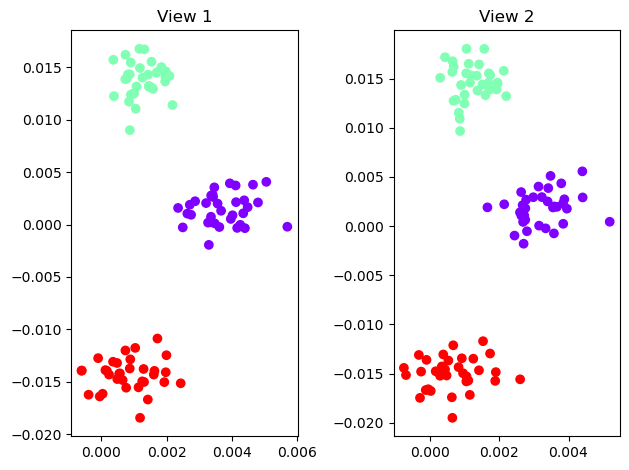

In [102]:
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt

# Sample data generation (2 views, 3 clusters)
n_samples = 100
n_features = 2
n_clusters = 3

# Generate synthetic data using make_blobs
data, true_labels = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters)

# Create two different views of the data (e.g., using different kernels)
# View 1: Original data
X1 = data @ data.T
X1 /= np.trace(X1)

# View 2: Rotated data (45 degrees clockwise)
# View 2: Data with added random noise
noise = np.random.normal(loc=0, scale=0.4, size=data.shape)
noisy_data = data + noise
X2 = noisy_data @ noisy_data.T
X2 /= np.trace(X2)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X1[:,0], X1[:,1], c=true_labels, cmap='rainbow') 
ax2.scatter(X2[:,0], X2[:,1], c=true_labels, cmap='rainbow')
ax1.set_title('View 1')
ax2.set_title('View 2');
plt.tight_layout()
plt.show()

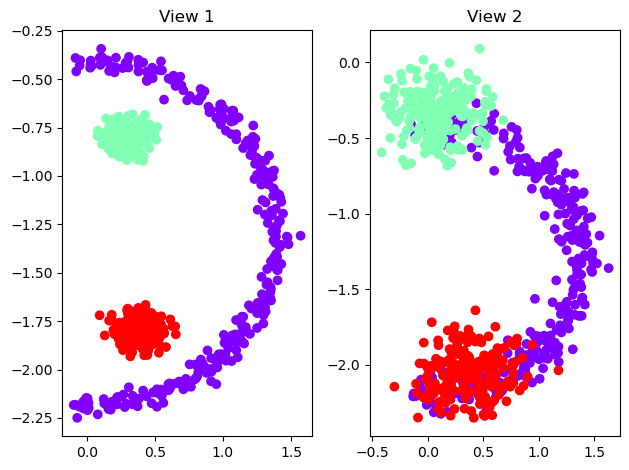

In [119]:
import scipy.io

data = scipy.io.loadmat('datasets/synthetic_data.mat')

X1 = data["View_1"]
X2 = data["View_2"]
true_labels = data["Ground_truth"]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(data["View_1"][:,0], data["View_1"][:,1], c=data["Ground_truth"], cmap='rainbow') 
ax2.scatter(data["View_2"][:,0], data["View_2"][:,1], c=data["Ground_truth"], cmap='rainbow')
ax1.set_title('View 1')
ax2.set_title('View 2');
plt.tight_layout()
plt.show()

In [121]:
# X1, y1 = make_blobs(n_samples=200, n_features=10, centers=2, cluster_std=0.2)
# X2, y2 = make_blobs(n_samples=200, n_features=10, centers=2, cluster_std=0.2)

ckm = CW2KM(n_clusters=3, max_iter=3, gamma=0.01)
ckm.fit([X1, X2])
labels = ckm.predict()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X1[:,0], X1[:,1], c=labels, cmap='rainbow') 
ax2.scatter(X1[:,0], X1[:,1], c=true_labels, cmap='rainbow')
ax1.set_title('View 1')
ax2.set_title('View 2');
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(X2[:,0], X2[:,1], c=labels, cmap='rainbow') 
ax2.scatter(X2[:,0], X2[:,1], c=true_labels, cmap='rainbow')
ax1.set_title('View 1')
ax2.set_title('View 2')
plt.tight_layout()
plt.show()

C:\Users\AbbasMn\AppData\Local\Temp\ipykernel_20184\1789307840.py:30: RuntimeWarning: invalid value encountered in double_scalars
  K_jj = soorat/makhraj
C:\Users\AbbasMn\AppData\Local\Temp\ipykernel_20184\1789307840.py:58: RuntimeWarning: invalid value encountered in double_scalars
  K_jj = soorat/makhraj


KeyboardInterrupt: 

In [107]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels, true_labels)
print(accuracy)

1.0


### Dataset: Handwritten numerals (HW)

In [53]:
import pandas as pd

V1 = pd.read_csv('datasets/HW/mfeat-fou', header=None, delimiter="\\s+")
V2 = pd.read_csv('datasets/HW/mfeat-fac', header=None, delimiter="\\s+")
V3 = pd.read_csv('datasets/HW/mfeat-kar', header=None, delimiter="\\s+")
V4 = pd.read_csv('datasets/HW/mfeat-pix', header=None, delimiter="\\s+")

views = [V1, V2, V3, V4]

ckm = CW2KM(n_clusters=10, max_iter=1, gamma=0.01)
ckm.fit(views)
labels = ckm.predict()

C:\Users\AbbasMn\AppData\Local\Temp\ipykernel_20184\1513541246.py:34: RuntimeWarning: invalid value encountered in double_scalars
  K_jj = soorat/makhraj


KeyboardInterrupt: 

In [ ]:
labels